# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [ ]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from functools import partial
from flbench.model import FieldLevelModel, default_config
from flbench.utils import pdump, pload
from flbench.mcbench import sample_and_save

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Import model and generate an observation

# CONFIG
{'a_obs': 0.5,
 'box_shape': array([320., 320., 320.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.02},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
 

2025-04-07 22:13:38.220393: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


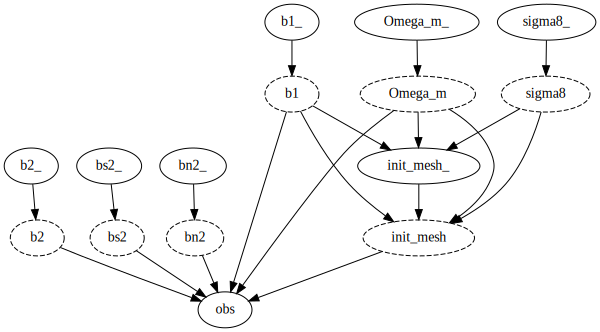

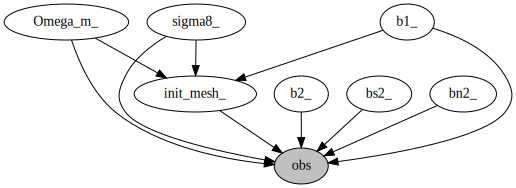

In [2]:
model = FieldLevelModel(**default_config | {'mesh_shape': 3* (32,)})
print(model)

save_dir = "save_dir/"
truth = {'Omega_m': 0.3, 
        'sigma8': 0.8, 
        'b1': 1.,
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
model.save(save_dir+"model.p")    
pdump(truth, save_dir+"truth.p")

model.block(hide_base=False)
model.render()

model.reset()
model.condition({'obs': truth['obs']})
model.block()
model.render()

## Infer from the observation

### Warmup 1

In [4]:
sampler = 'MCLMC'
n_samples, n_runs, n_chains = 32, 2, 8
tune_mass = True

model.reset()
model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
model.block()

init_params_ = jit(vmap(partial(model.kaiser_post, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), n_chains))    
init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']}

from flbench.samplers import get_mclmc_warmup
warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**12, config=None, 
                            desired_energy_var=1e-6, diagonal_preconditioning=False)))
state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_mesh_)

pdump(state, save_dir+f"init_last_state.p")
pdump(config, save_dir+f"init_conf.p")
init_params_ |= state.position

model.reset()
model.condition({'obs': truth['obs']})
model.block()

Perform 4096 adaptation steps
Performed 4096.0 adaptation steps


### Warmup 2 and Run

In [9]:
from tqdm import tqdm
from numpyro import infer


if sampler in ['NUTS', 'HMC']:
    
    if sampler == "NUTS":
        kernel = infer.NUTS(
            model=model,
            # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
            step_size=1e-3, 
            max_tree_depth=10,
            target_accept_prob=0.65,
            adapt_mass_matrix=tune_mass,
            )
        
    elif sampler == "HMC":
        kernel = infer.HMC(
            model=model,
            step_size=1e-3, 
            # Heuristic mean_length_steps_NUTS / 2, compare with gaussian pi.
            trajectory_length=4.4 / 2, 
            target_accept_prob=0.65,
            adapt_mass_matrix=tune_mass,
            )

    mcmc = infer.MCMC(
        sampler=kernel,
        num_warmup=n_samples,
        num_samples=n_samples, # for each run
        num_chains=n_chains,
        chain_method="vectorized",
        progress_bar=True,)
    
    mcmc_runned = sample_and_save(mcmc, save_dir, 0, n_runs, extra_fields=['num_steps'], init_params=init_params_)


elif sampler == 'NUTSwG':
    from flbench.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, 
                                         conf, 
                                         n_samples, 
                                         progress_bar=False)))
    state = vmap(init_state_fn)(init_params_)

    samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    jnp.savez(save_dir+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    pdump(state, save_dir+"last_state.p")
    pdump(conf, save_dir+'conf.p')
    pdump(tree.map(jnp.mean, infos), save_dir+'infos.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, 
                                     step_fn, 
                                     init_fn, 
                                     n_samples, 
                                     progress_bar=False)))
    key = jr.key(42)
    for i_run in tqdm(range(1, n_runs + 1)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)

        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_dir+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_dir+"last_state.p")



elif sampler == 'MAMS':
    from flbench.samplers import get_mams_warmup, get_mams_run
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    warmup_fn = jit(vmap(get_mams_warmup(model.logpdf, 
                                              n_steps=2**4, 
                                              config=None, 
                                              diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_params_)
    
    eval_per_ess = 5e2
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.3 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    pdump(state, save_dir+"last_state.p")
    pdump(config, save_dir+"conf.p")
    
    run_fn = jit(vmap(get_mams_run(model.logpdf, 
                                        n_samples, 
                                        thinning=1, 
                                        progress_bar=False)))

    key = jr.key(42)
    for i_run in tqdm(range(1, n_runs + 1)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("n_evals:", jnp.mean(samples['n_evals'], 1), '\n')
        jnp.savez(save_dir+f"_{i_run}.npz", **samples)
        pdump(state, save_dir+"last_state.p")


elif sampler == 'MCLMC':
    from flbench.samplers import get_mclmc_warmup, get_mclmc_run
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, 
                                        desired_energy_var=1e-6, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_params_)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    pdump(state, save_dir+f"last_state.p")
    pdump(config, save_dir+f"conf.p")
    
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=16, progress_bar=False)))

    key = jr.key(42)
    for i_run in tqdm(range(1, n_runs + 1)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
        jnp.savez(save_dir+f"_{i_run}.npz", **samples)
        pdump(state, save_dir+f"last_state.p")


Perform 16384 adaptation steps
Performed 14043.0 adaptation steps


  0%|          | 0/2 [00:00<?, ?it/s]

run 1/2


 50%|█████     | 1/2 [02:19<02:19, 139.52s/it]

MSE per dim: [1.01189827e-06 1.00048525e-06 8.94752212e-07 1.04229905e-06
 1.05311587e-06 8.95270720e-07 1.05770033e-06 8.16028156e-07] 

run 2/2


100%|██████████| 2/2 [02:56<00:00, 88.02s/it] 

MSE per dim: [9.69162846e-07 8.75103628e-07 9.29753012e-07 9.74622491e-07
 9.62553470e-07 9.96663351e-07 8.85341876e-07 9.16542927e-07] 

